# Introduction

Created on Tue Jun 25 11:31:21 2019


---



This notebook demonstrates the cleaning and preparing of experimental data
for use in machine learning models, building and training the
models, and testing the models' predictive performance. 

The data consists of optical, electrical, and gravimetric/viscoelastic
 properties of polymer mixture PEDOT:PSS thin
films.

All experimental data is referenced to the relative humidity (RH) at which
the measurement was performed. Here we explore correlations between changing
material properties and the ambient environment.

Questions can be directed at Eric Muckley (ericmuckley@gmail.com).


# Preparing experimental data

### Import relevant modules

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import splrep
from scipy.interpolate import splev

# this import is necessary when running the notebook in Google Colab cloud
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Some functions for plotting and formatting

In [0]:
def plot_setup(labels=['X', 'Y'], size=16, setlimits=False, limits=[0,1,0,1]):
    # This function can be used with Matplotlib for setting axes labels,
    # setting axes ranges, and setting the font size of plot labels
    plt.rcParams['xtick.labelsize'] = size 
    plt.rcParams['ytick.labelsize'] = size
    plt.rcParams.update({'figure.autolayout': True})
    plt.xlabel(str(labels[0]), fontsize=size)
    plt.ylabel(str(labels[1]), fontsize=size)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))

def arr_stretch(arr, new_len=100, new_xlims=None, vec_scale='lin', k=3, s=0):
    # Stretches or compresses an n-D array by using a spline fit.
    # Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values, next columns are y values.
    # If no x values exist, insert column np.arange(len(arr)) as x values.
    # Accepts linear or log x-values, and new x_limits.
    # k and s are degree and smoothing factor of the interpolation spline.
    # First, check whether array should be stretched using
    # a linear or log scale:
    if vec_scale == 'lin':
        new_scale = np.linspace
    if vec_scale == 'log':
        new_scale = np.geomspace
    # get new x-limits for the stretched array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold stretched values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into stretched array
        stretched_array[:, col] = arry
    return stretched_array

### Importing experimental data

The experimental daya is in the form of an Excel spreadsheet with
multiple sheets where each sheet corresponds to a different measurement.
Most of the data is spectral data (impedance as a function of frequency, at each RH level), so each RH value corresponds to an array of measured data.
The last sheet in the file is called "scalars" and corresponds to scalar data
(i.e. a single-value such as "current" measured at each RH level).

In [0]:
# Use this filepath when importing from a local machine
data_filepath = r'C:\Users\a6q\exp_data\pedotpss_multimode.xlsx'
# Use this filepath when importing from Google drive
data_filepath = 'gdrive/My Drive/pedotpss_multimode.xlsx'

# create a dictionary to hold all the raw data, so each sheet is put into a
# separate dictionary key
dict_raw = dict(pd.read_excel(data_filepath, None))
# initialize a new dictionary to hold the clean formatted data
dict_clean = {}

### Smoothing and preparing the input data 

Now we want to clean up our data and prepare it for building a predictive
model. This will be best when the data is clean, smooth, and dense.

To fill in missing gaps in the spectral data, we designate a new spectrum
length **_new_spec_len_**. We will stretch each spectrum to its full width
by fitting a spline and interpolating to fill in the gaps. The new number of
points that make up the specturm will now be equal to **_new_spec_len_**. This
way, we can control the size and density of our dataset without extrapolating
at all. To confirm that out interpolated data closely matches the original
data, we plot both.

After the spectral data is filled, we want to fill in the gaps in RH. Some
measurements were only measured at a small amount of RH values, but we can
interpolate the data using splines so that it is more dense. The new
list of RH values that we will interpolate at is called **_new_rh_list_**. 
Changing the values of this list will comtrol which RH levels we have
spectra for.

This block of code loops through each sheet (key) in our dictionary,
stretches the spectral data using a spline, and interpolates at the missing RH
values. For the scalar data, we only stretch across the RH values. 

After all this stretching / cleaning, we populate the new dictionary with
the cleaned interpolated data so its nicely organized. The clean data goes
into the dictionary **_dict_clean_**.

Finally, we plot all the raw and cleaned data together to ensure that nothing
changed when we performed the interpolations.

measurement = spe_n


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


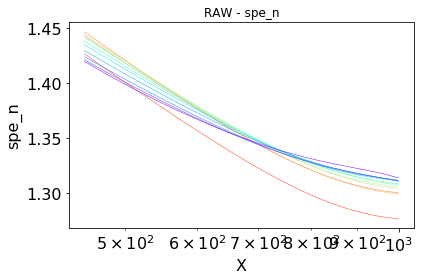

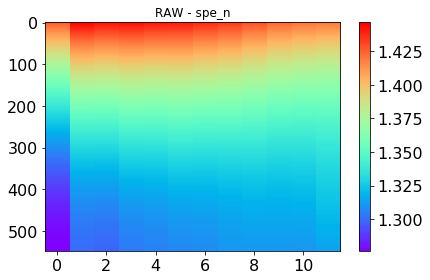

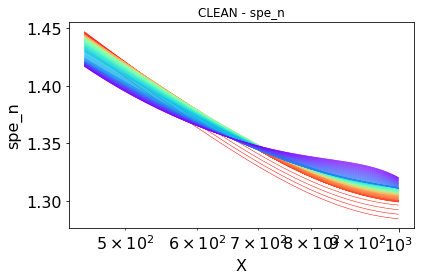

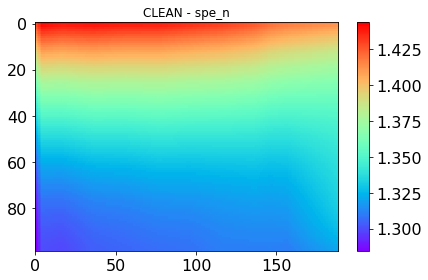

measurement = spe_k


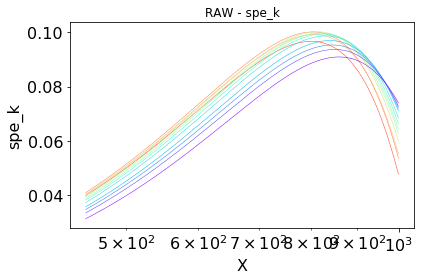

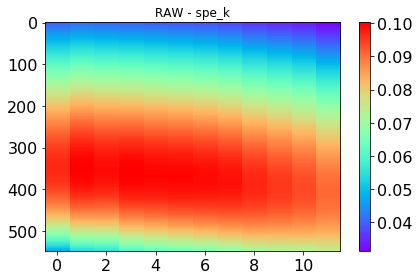

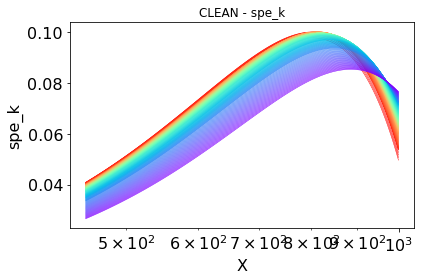

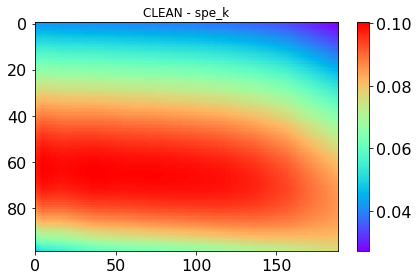

measurement = spe_psi


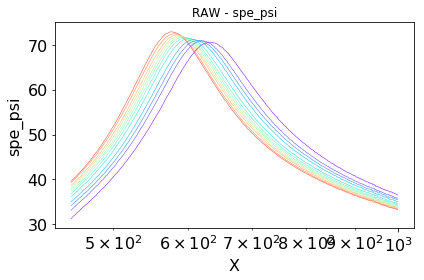

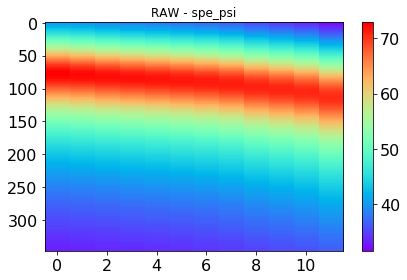

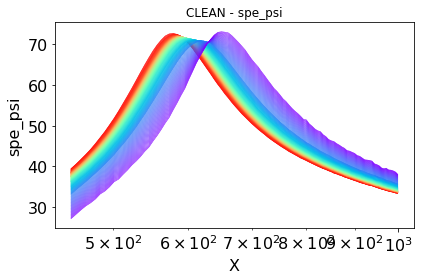

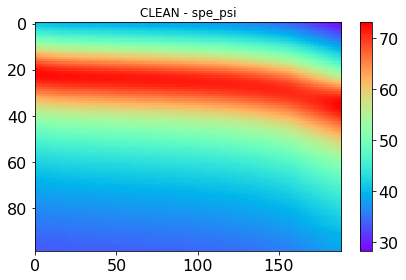

measurement = spe_delta


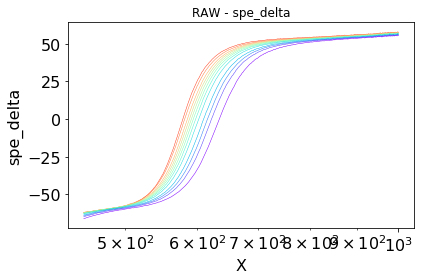

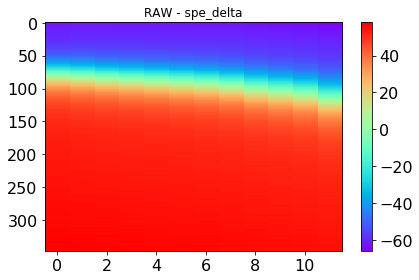

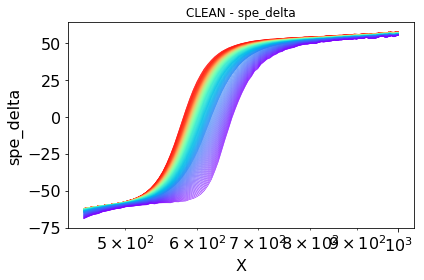

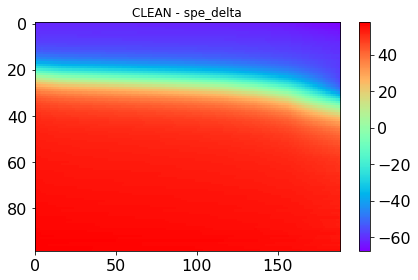

measurement = eis_z


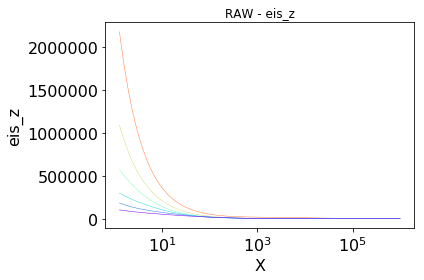

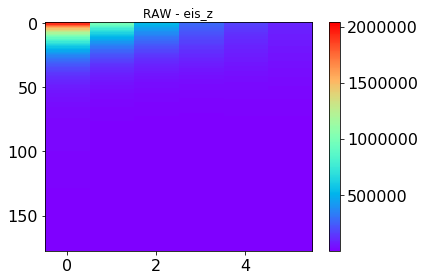

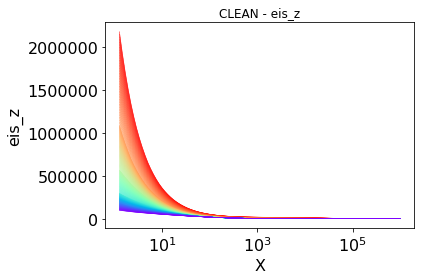

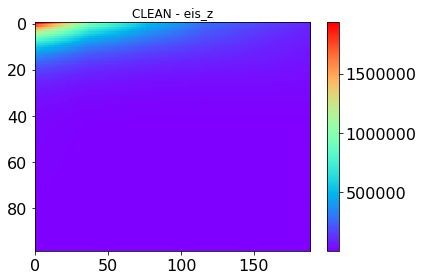

measurement = eis_phase


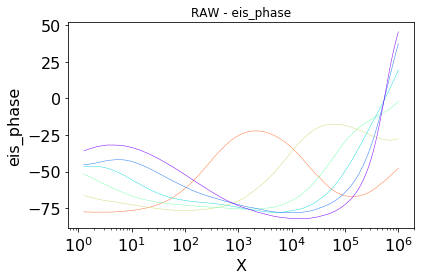

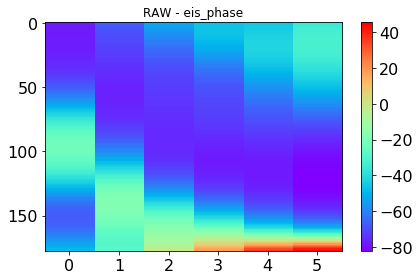

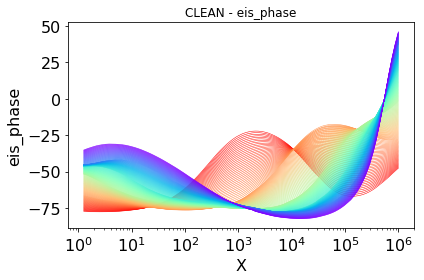

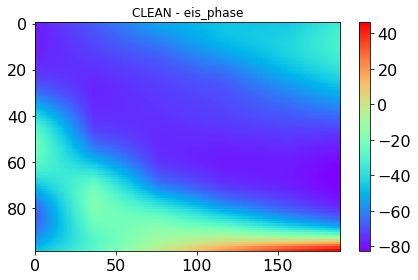

measurement = eis_rez


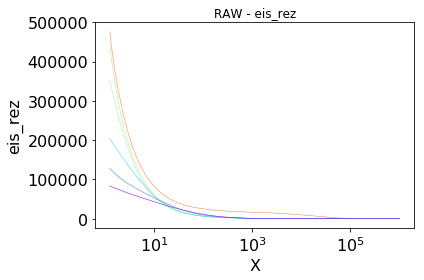

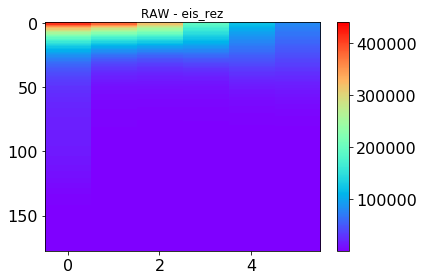

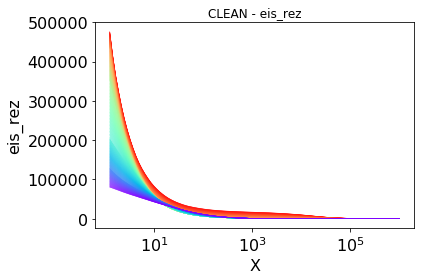

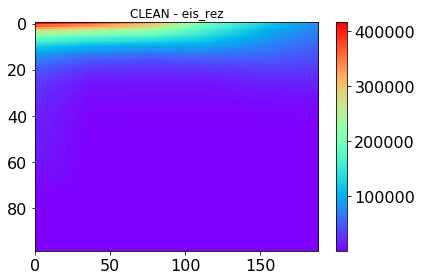

measurement = eis_imz


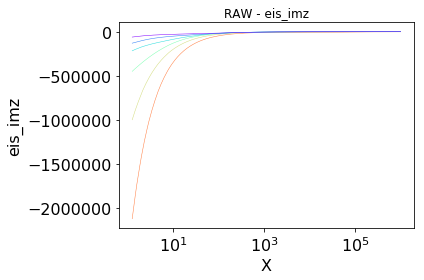

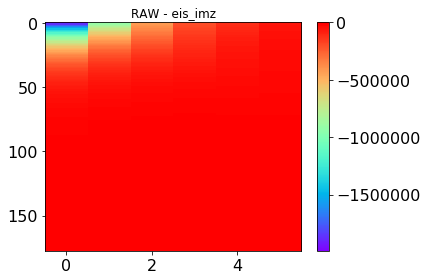

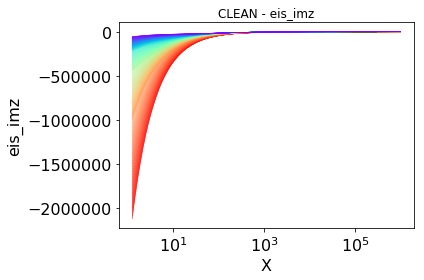

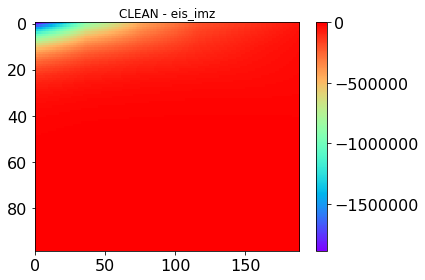

measurement = iv


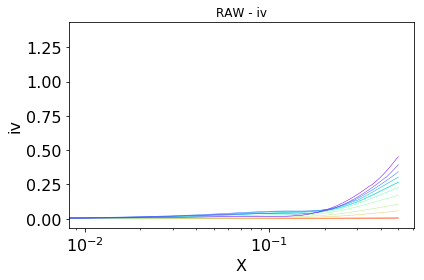

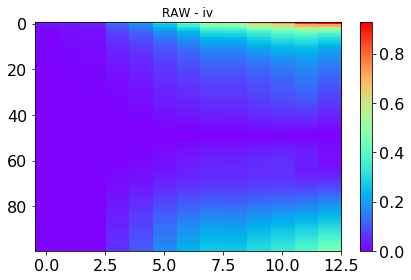

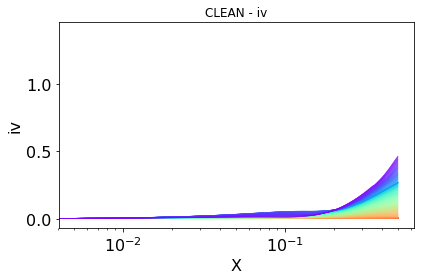

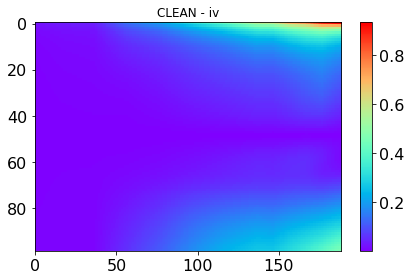

measurement = scalars


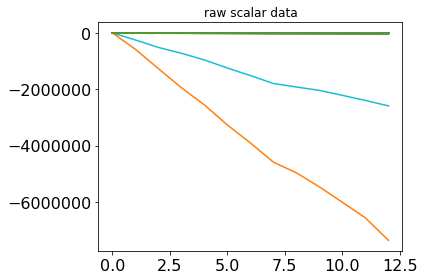

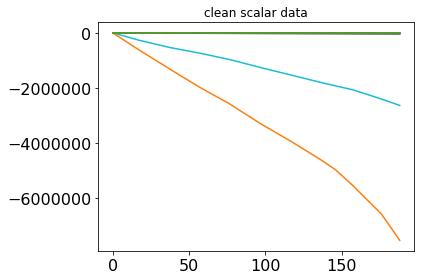

In [26]:
# new length for spectral data
new_spec_len = 100
# new values of RH to use for interpolation
new_rh_list = np.linspace(2, 96, num=189)

# loop over each sheet in file and stretch the measured data array
for mode in dict_raw:
    print('measurement = %s' % str(mode))

    # set linear or log scale for interpolation
    vec_scale = 'log' if 'eis_' in mode else 'lin'

    # for spectral data (each RH value is associated with vector data)
    if 'scalars' not in mode:
        # stretch array along spectrum axis
        spec_stretched = arr_stretch(dict_raw[mode].values,
                                     new_len=new_spec_len,
                                    vec_scale=vec_scale, k=1)

        # prepare to stretch along RH axis: transponse and add RH as x-values
        spec_stretched_transpose = np.insert(
                spec_stretched[:, 1:].T, 0, list(dict_raw[mode])[1:], axis=1)


        # stretch along RH axis
        rh_stretched = arr_stretch(spec_stretched_transpose,
                                new_len=len(new_rh_list),
                                new_xlims=[new_rh_list[0], new_rh_list[-1]],
                                k=1)

        # add x column and RH headers to stetched array and store as dataframe
        dict_clean[mode] = pd.DataFrame(data=np.insert(
            rh_stretched[:, 1:].T, 0, spec_stretched[:, 0], axis=1),
                columns=np.insert(new_rh_list.astype(str), 0, 'x'))

        # plot new and stretched versions
        for dic0, title0 in zip([dict_raw, dict_clean], ['RAW', 'CLEAN']):

            # line plots
            for col in range(1, len(list(dic0[mode]))):
                colors = cm.rainbow(
                    np.linspace(0, 1, len(list(dic0[mode]))))[::-1]
                if 'eis_' in mode:
                    plt.semilogx(dic0[mode].iloc[:, 0],
                            dic0[mode].iloc[:, col], color=colors[col], lw=0.5)
                else:
                    plt.semilogx(dic0[mode].iloc[:, 0],
                            dic0[mode].iloc[:, col], color=colors[col], lw=0.5)
                    
                plot_setup(labels=['X', str(mode)])
            plt.title(title0+' - '+str(mode))
            plt.show()

            # heatmap plots
            plt.imshow(dic0[mode].iloc[1:, 1:], aspect='auto', cmap='rainbow')
            plt.colorbar()
            plt.title(title0+' - '+str(mode))
            plt.show()

    # for non-spectral data (each RH value is associated with non-vector data)
    if 'scalars' in mode:
        spec_stretched = arr_stretch(dict_raw[mode].values,
                                     new_len=len(new_rh_list),
                                     new_xlims=[new_rh_list[0],
                                                new_rh_list[-1]],
                                    vec_scale=vec_scale, k=1)

        dict_clean[mode] = pd.DataFrame(data=spec_stretched,
                columns=list(dict_raw[mode]))

        plt.plot(dict_raw[mode])
        plt.title('raw scalar data')
        plt.show()
        plt.plot(dict_clean[mode])
        plt.title('clean scalar data')
        plt.show()

### Inspecting the clean input data

Now lets look at the cleaned data by examining the new RH values and the shape
and type of each measurement type. The new shapes are printed as
**_(x, y)_**, where **_x_** is the new length of the spectra and **_y_** is
the new length of the RH array. Each set of data is now saved inside its own
dataframe using the Pandas library.

In [37]:
# dispay the shape of the clean data
print('new RH list: %s' %new_rh_list)
num_of_samples = 0
for key in dict_clean:
    print('%s is %s of shape %s' %(key, 
                                   str(type(clean_dict[key])),
                                   str(np.shape(clean_dict[key]))))
    num_of_samples += np.prod(np.shape(dict_clean[key]))
print('total samples: %i' %num_of_samples)

new RH list: [ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5
 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5
 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5
 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5 50.  50.5
 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5 57.  57.5
 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5 64.  64.5
 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.  71.5
 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.  77.5 78.  78.5
 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.  84.5 85.  85.5
 86.  86.5 87.  87.5 88.  88.5 89.  89.5 90.  90.5 91.  91.5 92.  92.5
 93.  93.5 94.  94.5 95.  95.5 96. ]
spe_n is <class 'pandas.cor

### Saving the clean input data to a file

We want to save this cleaned data to a file so we can easily import it
somewhere else later. For this we use pickle to serialize the data so it can
 be read back later. We are 

In [0]:
# save clean data dictionary to file.
# this filename can be changed to a specific directory on the local PC
clean_data_filename = 'pp_multimode.pkl'

# store data (serialize)
with open(clean_data_filename, 'wb') as h:
    pickle.dump(dict_clean, h, protocol=pickle.HIGHEST_PROTOCOL)

# since we saved the file to Google Colab, now we download it to our local PC
# this step is not necessary when saving the file to a local PC
from google.colab import files
files.download(clean_data_filename)

# Building models in Keras / Tensorflow

Now that the data is clean and formatted, we can prepare it for use in building
a predictive model. We will first look at using Keras, a wrapper for Google's
Tensorflow machine learning library. 

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed
import keras
from keras import optimizers
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from timeit import default_timer as timer

 ### Fixing the random number generators

 Ransom number generators are often used to create initial values for
 weights and biases of the model. Here we fix the numpy and tensorflow random
  number generators so we can reproduce the model results each time we run the
  code. This is not esential but it helps for judging the model performance 
  when a model parameter is changed, since our model will always begin in
  the same initialization state.

In [0]:
seed(1)
set_random_seed(2)

### Creating a callback function

When we train an artificial neural network, it is difficult to tell how many
layers and how many neurons to use. To get some insights, we want to know how
the weights and biases of each layer and neuron are changing during training.

For reading the value of weights at each training epoch, we write a special
Keras callback function which runs at each epoch and stores the weights and
biases of each neuron in every layer. This will be called when we fit the
neural network model.

In [0]:
class GetWeights(Callback):
    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}
    def on_epoch_end(self, epoch, logs=None):
        # this function runs at the end of each epoch
        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]
            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create array to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights array
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                # append new weights to previously-created weights array
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b)) 

### Importing the clean data

Now we import the saved clean data we formatted earlier. This is not necessary
if we are working in the same envinrment, since the variable **_clean_dict_**
will be saved. But it is a good demonstration of the use of Python's _Pickle_
serialization library.

In [52]:
# import the saved data file with cleaned data
# here we will use cd for 'clean data'
with open(clean_data_filename, 'rb') as handle:
   cd = pickle.load(handle)

for key in cd:
    print('%s is %s of shape %s' %(key,
                                   str(type(cd[key])),
                                   str(np.shape(cd[key]))))
print('scalars columns:')
print(np.array(list(cd['scalars'])))

spe_n is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
spe_k is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
spe_psi is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
spe_delta is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
eis_z is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
eis_phase is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
eis_rez is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
eis_imz is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
iv is <class 'pandas.core.frame.DataFrame'> of shape (100, 190)
scalars is <class 'pandas.core.frame.DataFrame'> of shape (189, 23)
scalars columns:
['rh' 'df1' 'dd1' 'df7' 'dd7' 'df11' 'dd11' 'dmu1' 'deta1' 'dmu7' 'deta7'
 'dmu11' 'deta11' 'cvarea10' 'cvarea50' 'cvarea100' 'cvarea300' 'cvmax10'
 'cvmax50' 'cvmax100' 'cvmax300' 'ivmaxcurr' 'ivmincurr']


In [56]:
from sklearn.preprocessing import StandardScaler

cd['scalars']

print(np.amax(cd['scalars'].values))
print(np.amin(cd['scalars'].values))

2721.8579636650343
-7525914.849332529


### Prepare data for training the model

Now we must designate which data will be used for inputs and which will
be used for targets of the model. Our input matrix **_input_mat_** holds
 all the data going into the model. Then we select a specific column of 
 **_input_mat_** to use as the model targets (**_tar_col_**).

In [32]:



input_mat = np.random.random((10000, 16))
input_mat[:, 0] = np.arange(len(input_mat))**(1/2)
input_mat[:, 1] = -np.arange(len(input_mat))*0.1
input_mat[:, 2] = -np.arange(len(input_mat))
input_mat[:, 3] = np.arange(len(input_mat))**(3)/1000
input_mat[:, 4] = np.arange(len(input_mat))-100

input_mat[:, -1] = np.arange(len(input_mat))
tar_col = len(input_mat[0]) - 1




a = np.logspace(-3, 8, 15)
print(a)
print(np.log(a))





[1.00000000e-03 6.10540230e-03 3.72759372e-02 2.27584593e-01
 1.38949549e+00 8.48342898e+00 5.17947468e+01 3.16227766e+02
 1.93069773e+03 1.17876863e+04 7.19685673e+04 4.39397056e+05
 2.68269580e+06 1.63789371e+07 1.00000000e+08]
[-6.90775528 -5.09858128 -3.28940728 -1.48023327  0.32894073  2.13811473
  3.94728873  5.75646273  7.56563673  9.37481074 11.18398474 12.99315874
 14.80233274 16.61150674 18.42068074]


In [0]:
# sizes of train and test sets
percent_to_train = 70
train_size = int(len(input_mat) * percent_to_train/100) 
test_size= len(input_mat) - train_size

# normalization and splitting into train/test sets
scaler = MinMaxScaler(feature_range=(0, 1))
# prefix "_s" = scaled 
training_mat_s = scaler.fit_transform(input_mat)
train_inp_s =  training_mat_s[:train_size, :-1]
train_tar_s = training_mat_s[:train_size, tar_col].reshape((train_size, 1))
test_inp_s = training_mat_s[train_size:, :-1]
test_tar_s = training_mat_s[train_size:, tar_col]


Now we can build the structure of the neural network, set the optimizers,
compile the model, and finally fit (train) it. We plot the history of the model
during training to track how many epochs it should complete before the
model starts overtraining (validation loss begins increasing).

Train on 5950 samples, validate on 1050 samples
Epoch 1/5
5950/5950 [==============================] - 0s 28us/step - loss: 0.1155 - val_loss: 0.0642
Epoch 2/5
5950/5950 [==============================] - 0s 4us/step - loss: 0.0148 - val_loss: 0.0264
Epoch 3/5
5950/5950 [==============================] - 0s 3us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/5
5950/5950 [==============================] - 0s 3us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 5/5
5950/5950 [==============================] - 0s 3us/step - loss: 0.0015 - val_loss: 0.0025
training time = 0.5 sec (0.01 min)


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


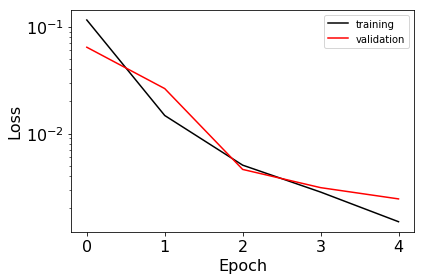

In [35]:
# instantiate our previously-defined callback class       
gw = GetWeights()

# create the neural network structure
train_start_time = timer()
model = Sequential([
                    Dense(24, activation='relu',
                          input_shape=(train_inp_s.shape[1:])),

                    #Dense(4, activation='relu'),
                    #Dense(8, activation='relu',
                    #Dense(4, activation='relu'),
                    #Dropout(.2, seed=1),
                  Dense(1)])

# set hyperparameters related to the stochastic gradient descent optimizer
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

# compile the model with optimizer and loss function
model.compile(loss='mean_squared_error', optimizer=sgd)

# train the model
epochs = 5

history= model.fit(train_inp_s, train_tar_s,
                   validation_split=0.15,
                   epochs=epochs,
                   batch_size=500,
                   verbose=1,
                   callbacks=[gw])
print('training time = %.1f sec (%.2f min)' %(timer()-train_start_time,
                                 (timer()-train_start_time)/60))

# plot loss during training
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.semilogy(loss, c='k')
plt.semilogy(val_loss, c='r')
plot_setup(['Epoch', 'Loss'])
plt.legend(['training', 'validation'])
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


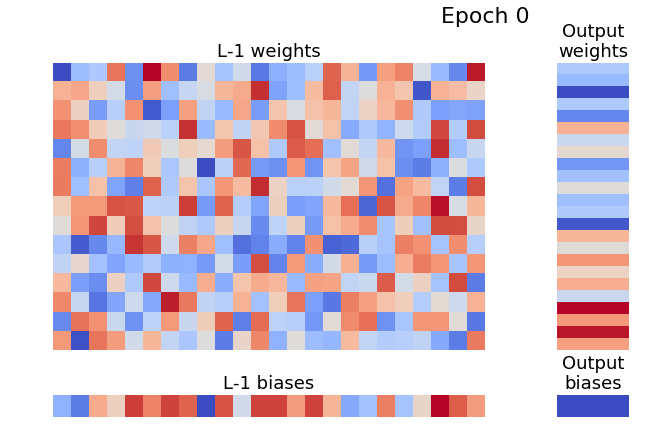

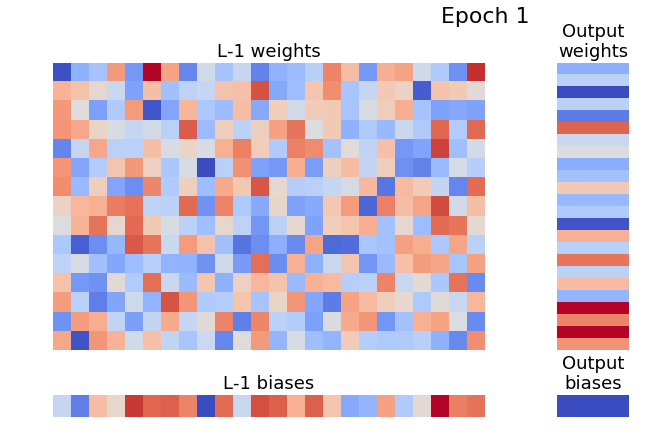

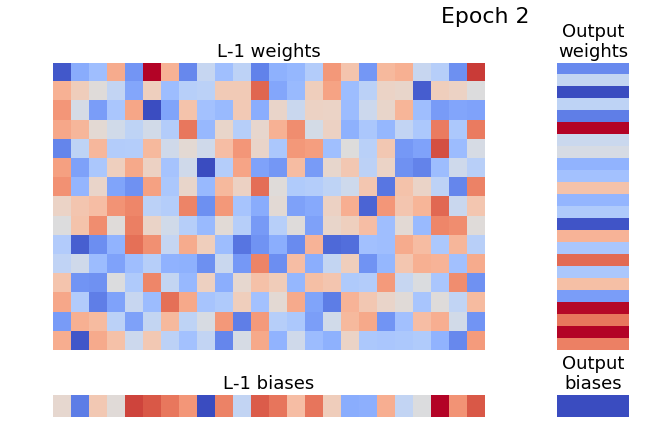

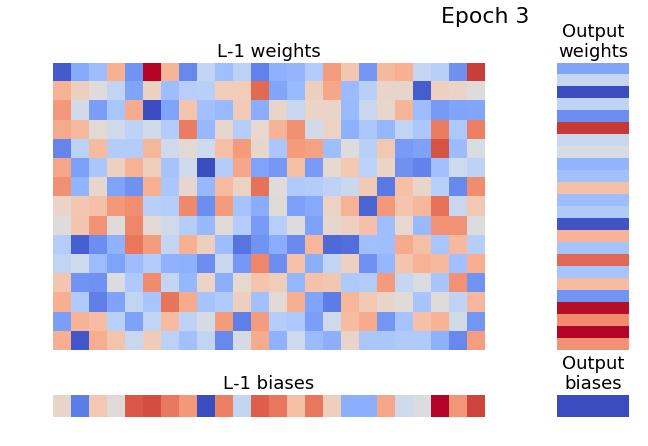

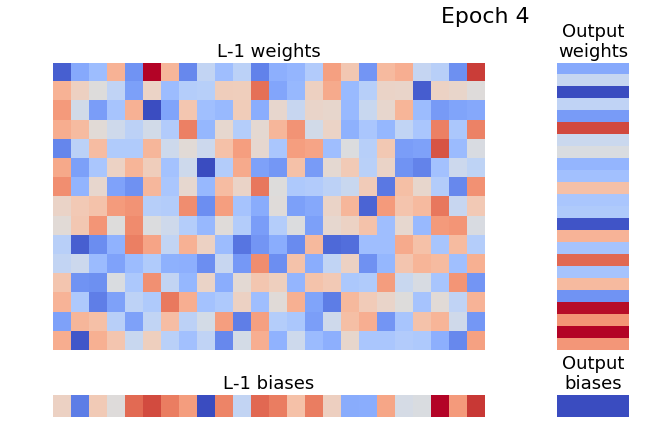

IndexError: ignored

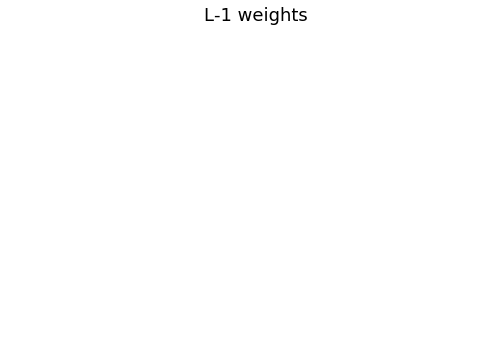

In [36]:
import matplotlib.gridspec as gridspec
from matplotlib import cm

wd = gw.weight_dict

# loop over each epoch in the training session
for epoch in range(0, 20, 1):
    # layout the figure based on the number of layers
    fig = plt.figure(figsize=(15, 6))
    gs_stretch = 6
    gs = gridspec.GridSpec(6, int(len(wd)/2)*gs_stretch, figure=fig)
    gs.update(left=0.1, right=0.9, top=0.85, bottom=0.03, wspace=0.01, hspace=2)

    # loop over each array of weights and biases
    for key_i, key in enumerate(wd):
        # print(str(key) + ' shape: %s' %str(np.shape(gw.weight_dict[key])))
        # check if key is a weights key
        if 'w' in key:
            # row and column to place plot
            row, col = gs.get_geometry()[0]-1, gs_stretch*int(key_i/2)+int(key_i/2)
            # normal layer
            if key != list(wd.keys())[-2]:
                plt.subplot(gs[:row, col:col+gs_stretch]).axis('off')
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' weights', fontsize=18)
            # output layer
            else:
                plt.subplot(gs[:row, col]).axis('off')
                plt.gca().set_title('Output\nweights', fontsize=18)
        # check if key is a biases key
        if 'b' in key:
            # normal layer
            if key != list(wd.keys())[-1]:
                plt.subplot(gs[row, col:col+gs_stretch]).axis('off') 
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' biases', fontsize=18) 
            # output layer
            else:
                plt.subplot(gs[row, col]).axis('off')
                plt.gca().set_title('Output\nbiases', fontsize=18)

        # generate the heatmap of weight/bias values
        plt.imshow(wd[key][:,:,epoch],
                aspect='auto',
                cmap=plt.get_cmap('coolwarm'),
                interpolation='nearest')

    fig.suptitle('Epoch '+str(epoch), fontsize=22)
    plt.axis('off')
    plt.show()
    # save the image to file
    fig_filename = 'epoch_'+str(epoch).zfill(5)+'.png'
    #fig.savefig(fig_filename, dpi=200)
    #files.download(fig_filename)

### Animating the weights into a video clip

We want to visualize how the neural network model weights and biases are 
changing as the model is trained so we can tell which layers are 
superfluous and merely contribute to longer training times and overfitting.

We use the OpenCV library (imported as cv2) to compile the saved images of our
 weights in a short video. 

In [0]:
from glob import glob
import cv2

def create_video(image_list, video_name, fps=8, reverse=False):
    # create video out of images saved in a folder
    # frames per second (fps) and order of the images can be reversed 
    # using the **kwargs.
    if reverse: image_list = image_list[::-1]
    frame = cv2.imread(image_list[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, fps, (width,height))
    for image in image_list:
        video.write(cv2.imread(image))
    cv2.destroyAllWindows()
    video.release()
    return video

image_list = sorted(glob(r'C:\Users\a6q\exp_data\ANN_weight_maps\/*.png'))

video = create_video(image_list,
                     r'C:\Users\a6q\Desktop\ANN_weightmap.avi',                     
                     fps=4)

In [0]:
'''
#%% make predictions
trained_model_s = model.predict(train_inp_s), 
future_predictions_s = model.predict(test_inp_s)

#%% get sparse matrices which have same shape as scaled 
# training/testing data so we can unscale ANN results
# so we can unscale using the same scaler as before
trained_model_mat_s = np.zeros((train_size,len(input_mat[0])))
future_predictions_mat_s = np.zeros((test_size,len(input_mat[0])))
test_tar_mat_s = np.copy(future_predictions_mat_s)

# insert our data into its corresponding column of each sparse matrix
trained_model_mat_s[:,tar_col] = np.ndarray.flatten(np.array(trained_model_s))
future_predictions_mat_s[:,tar_col] = np.ndarray.flatten(future_predictions_s)


#%%# unscale our data
trained_model = scaler.inverse_transform(trained_model_mat_s)[:,tar_col]
future_pred = scaler.inverse_transform(future_predictions_mat_s)[:,tar_col]
train_tar = sig[:train_size]

plt.plot(time[train_size:],future_pred, c='r', label='prediction')
plt.scatter(time, sig, c='k', s=3, alpha=0.1, label='measured')
plt.plot(time[:train_size], trained_model, c='b', alpha=0.5, label='model')
plt.xlabel('Time (min)', fontsize=label_size)
plt.ylabel('Amplitude', fontsize=label_size)
plt.legend()
plt.show()

#%% make error calculations
tot_model = np.append(trained_model, future_pred)
error_raw = np.subtract(sig, tot_model)
percent_error = 100*np.abs(error_raw)/np.max(np.abs(sig))

fig, ax1 = plt.subplots()
ax1.plot(time, pressure, linewidth=0.5, c='b')
ax1.set_xlabel('Time (min)', fontsize=label_size)
ax1.set_ylabel('Pressure', color='b', fontsize=label_size)

ax2 = ax1.twinx()
ax2.plot(time, percent_error, linewidth=0.5, c='r')
ax2.set_ylabel('% error', color='r', fontsize=label_size)
ax2.tick_params('y', colors='r')
plt.show()

print('avg. percent error = %.2f' %(np.mean(percent_error)))
'''